In [1]:
from missing_bids import auction_data, analytics, environments
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('white')
%matplotlib inline

In [2]:
def check_ic(dev, dev_demand, eq_demand, cost):
    return dev_demand * ((1 + dev) - cost)  < eq_demand * (1 - cost)

## auction analysis packages
- `auction_data` provides tools to access, compute statistics of interest, and manipulate procurement auction data
- `analytics` provides tools to setup and solve a variety of safe tests as described in 

    ''Data-Driven Regulation: Theory and Application to Missing Bids'' (Chassang, Kawai, Nakabayashi and Ortner)
- `environments` is a module that helps specify constraints on, as well as generate, economic environments

## `auction_data`

First, we'll use `auction_data` to plot the distribution of winning margins, as well as the aggregate demand for auctions in the Tsuchiura dataset.

In [3]:
tsuchiura_data = auction_data.AuctionData('../tests/reference_data/tsuchiura_data.csv')

In [4]:
tsuchiura_data.df_bids.norm_bid.describe()

count    5876.000000
mean        0.946066
std         0.069519
min         0.099475
25%         0.949772
50%         0.974774
75%         0.984912
max         1.034483
Name: norm_bid, dtype: float64

/home/sylvain/.virtualenvs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


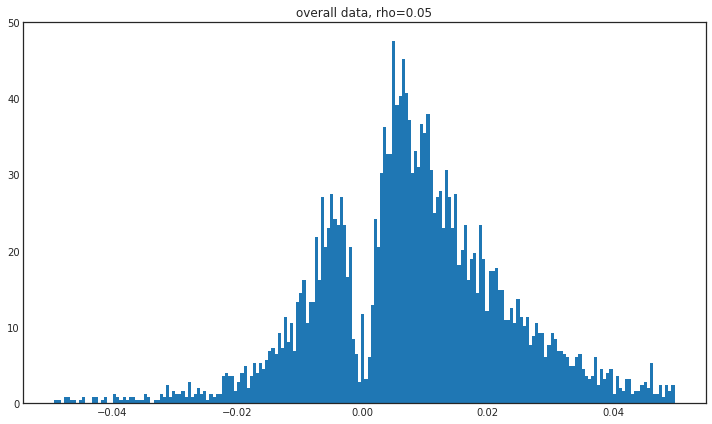

/home/sylvain/.virtualenvs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


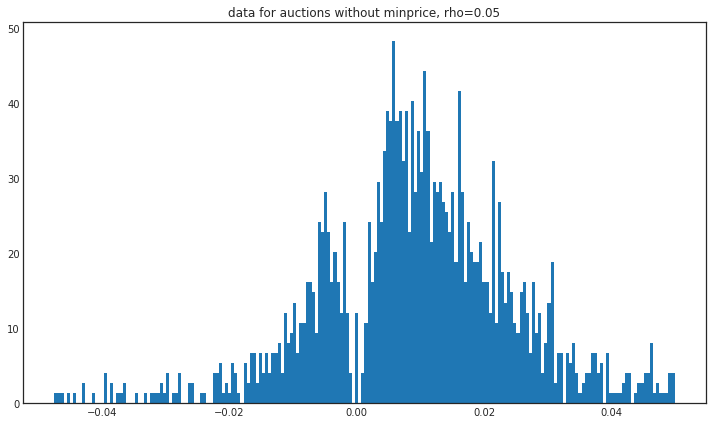

/home/sylvain/.virtualenvs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


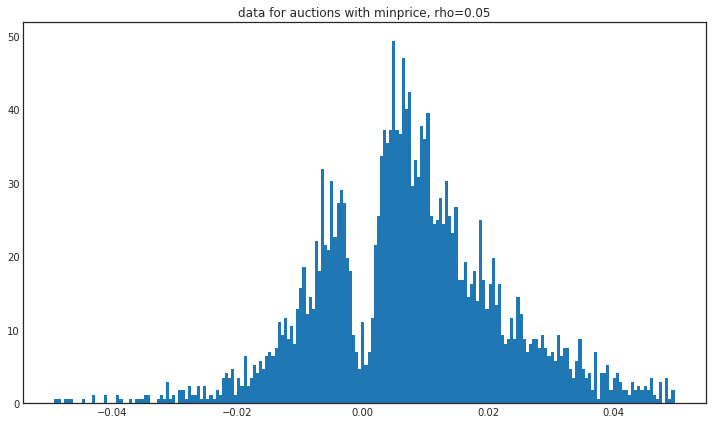

In [5]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta, 'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data.data.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data.data.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

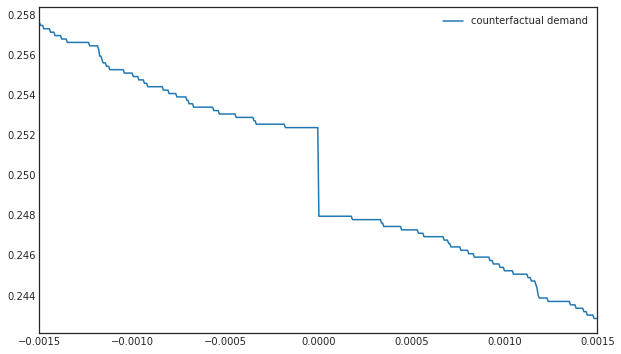

In [6]:
tsuchiura_data.demand_function(-.0015, .0015).plot(figsize = (10,6))

### `AuctionData` objects can be seeded using a selected dataframe

In [7]:
tsuchiura_before_min_price = auction_data.AuctionData(tsuchiura_data.df_bids.loc[tsuchiura_data.data.minprice.isnull()])

/home/sylvain/.virtualenvs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


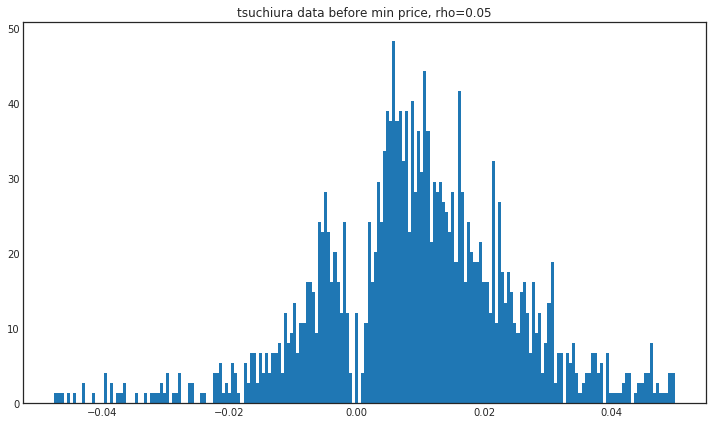

In [8]:
delta = tsuchiura_before_min_price.df_bids.norm_bid - tsuchiura_before_min_price.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta, 'tsuchiura data before min price, rho={}'.format(rho))

## `analytics`

Next, we use `analytics` to compute the minimum number of non-competitive histories, as well as the minimum normalized deviation temptation respectively corresponding to deviations $[-.015, 0, .002]$ and $[-.015, 0, .015]$

### Share of collusive auctions

#### level moment condition
We first consider the case were constraints are applied on demand levels 

In [9]:
deviations = [-.02, .0, .002]
demands = [tsuchiura_before_min_price.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6589912280701754, 0.21792763157894735, 0.20614035087719298]


In [10]:
constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.02), 
               environments.InformationConstraint(k=.5, sample_demands=demands)]
filter_ties = auction_data.FilterTies(tolerance=.0001)

In [11]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.IsNonCompetitive, 
    plausibility_constraints=constraints, 
    num_points=1000.0, 
    seed=0, 
    project=True, 
    filter_ties=filter_ties,
    number_iterations=50,
    confidence_level=.95,
    moment_matrix=auction_data.moment_matrix(deviations, 'level')
)

In [12]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))

solver demands: [0.65761773 0.21772853 0.20831025]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: 0.000854505413555758


In [13]:
result = min_collusion_solver.result
print('minimum share of collusive auctions: {}'.format(result.solution))
result.argmin.head()

minimum share of collusive auctions: -2.8397428289025406e-11


,-0.02,0.0,0.002,cost,metric,prob
0,0.632857,0.207745,0.193441,0.972652,0.0,0.446309
1,0.693749,0.245661,0.224986,0.969500,0.0,0.055464
2,0.739933,0.282147,0.247243,0.977717,0.0,0.049517
3,0.677403,0.241714,0.203993,0.977111,0.0,0.031968
4,0.759206,0.257604,0.232503,0.974973,0.0,0.015978


#### slope moment condition

In [14]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.IsNonCompetitive, 
    plausibility_constraints=constraints, 
    num_points=1000.0, 
    seed=0, 
    project=True, 
    filter_ties=filter_ties,
    number_iterations=50,
    confidence_level=.95,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.array([0, 0, 1])
)

In [15]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))

solver demands: [0.65761773 0.21772853 0.20831025]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: 1.5039786373646638e-05


In [16]:
result = min_collusion_solver.result
print('minimum share of collusive auctions: {}'.format(result.solution))
result.argmin.head()

minimum share of collusive auctions: 0.06045812405594729


,-0.02,0.0,0.002,cost,metric,prob
0,0.679814,0.180762,0.167170,0.973832,0.0,9.395405e-01
1,0.718768,0.149103,0.140390,0.942112,1.0,6.044733e-02
2,0.694926,0.151215,0.142425,0.884216,1.0,6.813659e-06
3,0.608281,0.154324,0.145437,0.968144,1.0,1.059320e-06
4,0.734777,0.157642,0.148624,0.928377,1.0,5.397695e-07


### Minimum deviation temptation

In [77]:
deviations = [-.02, .0, .01]
demands = [tsuchiura_before_min_price.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6589912280701754, 0.21792763157894735, 0.09758771929824561]


In [86]:
constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.01), 
               environments.InformationConstraint(k=.5, sample_demands=demands)]

In [87]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.NormalizedDeviationTemptation, 
    plausibility_constraints=constraints, 
    num_points=1000.0,
    seed=0, 
    project=True, 
    number_iterations=50,
    confidence_level=.95,
    filter_ties=filter_ties,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.array([0, 0, 1])
)

In [88]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))

solver demands: [0.65761773 0.21772853 0.09861496]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: 0.00019343006883004206


In [89]:
result = min_collusion_solver.result
print('minimum deviation temptation: {}'.format(result.solution))
result.argmin.head()

minimum deviation temptation: -1.1079082441321539e-14


,-0.02,0.0,0.01,cost,metric,prob
0,0.608281,0.154324,0.066691,0.977472,0.0,0.075992
1,0.743145,0.163410,0.069015,0.977346,0.0,0.051607
2,0.606823,0.182111,0.077797,0.989140,0.0,0.046612
3,0.663129,0.171066,0.067479,0.986847,0.0,0.044388
4,0.674790,0.170271,0.067147,0.986560,0.0,0.044331
